In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
SEQ_LEN = 512
BATCH_SIZE = 256
DEVICE = 'cuda'
RUBERT_OUT = 312
TEST_SIZE = 0.1
EPOCHS = 20

In [3]:
class TextClassificationDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=SEQ_LEN):
        self.texts = df['clean_content'].to_list()
        self.targets = df['sentiment'].to_list()  #encoded
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        item = {k:v.squeeze(0) for k,v in encoding.items()}
        item['labels'] = torch.tensor(self.targets[idx], dtype=torch.long)
        
        return item

In [4]:
class MyTinyBERT(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(
            'cointegrated/rubert-tiny2'
        )
        
        for name, param in self.bert.named_parameters():
            if 'encoder.layer.10' in name or 'encoder.layer.11' in name:
                param.requires_grad=True
            else:
                param.requires_grad=False
                
        self.norm = nn.LayerNorm(RUBERT_OUT)
        self.linear = nn.Sequential(
            nn.Linear(RUBERT_OUT, RUBERT_OUT),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(RUBERT_OUT, RUBERT_OUT//2),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(RUBERT_OUT//2, n_classes)
        )
        
    def mean_pooling(self, model_output, attention_mask):
        token_embedings = model_output.last_hidden_state # [b:t:h]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(
            token_embedings.size()
        )
        sum_embeddings = torch.sum(
            token_embedings * input_mask_expanded, dim=1
        )
        sum_mask = input_mask_expanded.sum(dim=1).clamp(min=1e-9)
        
        return sum_embeddings / sum_mask
    
    def forward(self, x):
        bert_out = self.bert(
            input_ids=x['input_ids'],
            attention_mask=x['attention_mask']
        )
        
        pooled=self.mean_pooling(bert_out, x['attention_mask'])
        pooled=self.norm(pooled)
        out=self.linear(pooled)
        
        return out

In [5]:
df = pd.read_csv('../data/cleaned_df.csv')
df.drop(columns=['Unnamed: 0', 'review_id'], inplace=True)

In [6]:
df.head()

,category,title,content,sentiment,source_url,clean_content
0,Поликлиники стоматологические,Классный мастер,Огромное спасибо за чудесное удаление двух зуб...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2727539,огромный спасибо чудесный удаление зуб мудрост...
1,Поликлиники стоматологические,Замечательный врач,Хочу выразить особую благодарность замечательн...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2302877,хотеть выразить особый благодарность замечател...
2,Поликлиники стоматологические,Благодарность работникам рентгена,Добрый вечер! Хотелось бы поблагодарить сотруд...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2815031,добрый вечер хотеться поблагодарить сотрудник ...
3,Поликлиники стоматологические,Доктор Рабинович,Женщины советского образца в регистратуре не и...,negative,http://www.spr.ru/forum_vyvod.php?id_tema=3443161,женщина советский образец регистратура не имет...
4,Поликлиники стоматологические,Есть кому сказать спасибо,У меня с детства очень плохие зубы (тонкая и х...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2592430,детство очень плохой зуб тонкий хрупкий эмаль ...


In [7]:
df['content_len'] = df['clean_content'].apply(lambda x: len(x))

In [8]:
df['content_len'].describe()

count    70597.000000
mean       463.906002
std        435.466465
min          7.000000
25%        205.000000
50%        336.000000
75%        561.000000
max       4088.000000
Name: content_len, dtype: float64

In [9]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

In [10]:
encoder = {
    'negative':0,
    'positive':1
}

X = df.loc[:, 'clean_content']
y = df.loc[:, 'sentiment'].map(encoder)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=13
)

In [12]:
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_test, y_test], axis=1)

In [13]:
train_ds = TextClassificationDataset(train_df, tokenizer)
val_ds = TextClassificationDataset(valid_df, tokenizer)

In [14]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [15]:
sample_batch = next(iter(train_loader))
sample_batch

{'input_ids': tensor([[    2, 27211, 13949,  ...,     0,     0,     0],
         [    2, 33020, 13114,  ...,     0,     0,     0],
         [    2, 53369, 33904,  ...,     0,     0,     0],
         ...,
         [    2, 31925,  1614,  ...,     0,     0,     0],
         [    2, 40096,   656,  ...,     0,     0,     0],
         [    2, 23016, 38638,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 1, 0, 1, 0, 1, 1, 1, 1,

In [16]:
model = MyTinyBERT(n_classes=df["sentiment"].nunique()).to(DEVICE)
optimizer = torch.optim.Adam(model.linear.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [19]:
best_val_loss = 0.1863

In [18]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        labels = batch.pop('labels').to(DEVICE)
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        
        logits = model(batch)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    avg_loss = total_loss / total
    train_acc = correct / total
    
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            labels = batch.pop('labels').to(DEVICE)
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            
            logits = model(batch)
            loss = criterion(logits, labels)
            
            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            
    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )
    
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model, f'bert_best_{avg_val_loss:.2f}.pt')
        torch.save(model.state_dict(), f'bert_best_{avg_val_loss:.2f}.pth')
            

Epoch 1/20 | Train Loss: 0.2609, Train Acc: 0.8932 | Val Loss: 0.2253, Val Acc: 0.9106
Epoch 2/20 | Train Loss: 0.2300, Train Acc: 0.9077 | Val Loss: 0.2037, Val Acc: 0.9210
Epoch 3/20 | Train Loss: 0.2222, Train Acc: 0.9115 | Val Loss: 0.1969, Val Acc: 0.9246
Epoch 4/20 | Train Loss: 0.2147, Train Acc: 0.9150 | Val Loss: 0.2029, Val Acc: 0.9201
Epoch 5/20 | Train Loss: 0.2112, Train Acc: 0.9163 | Val Loss: 0.2156, Val Acc: 0.9153
Epoch 6/20 | Train Loss: 0.2077, Train Acc: 0.9184 | Val Loss: 0.1963, Val Acc: 0.9242
Epoch 7/20 | Train Loss: 0.2042, Train Acc: 0.9192 | Val Loss: 0.1916, Val Acc: 0.9266
Epoch 8/20 | Train Loss: 0.2000, Train Acc: 0.9223 | Val Loss: 0.1951, Val Acc: 0.9207
Epoch 9/20 | Train Loss: 0.1965, Train Acc: 0.9234 | Val Loss: 0.1973, Val Acc: 0.9205
Epoch 10/20 | Train Loss: 0.1962, Train Acc: 0.9226 | Val Loss: 0.1870, Val Acc: 0.9249
Epoch 11/20 | Train Loss: 0.1920, Train Acc: 0.9248 | Val Loss: 0.1863, Val Acc: 0.9278
Epoch 12/20 | Train Loss: 0.1895, Train A

In [20]:
preds = []
for batch in val_loader:
    with torch.inference_mode():
        labels = batch.pop("labels").to(DEVICE)
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        logits = model(batch)
    preds.extend(logits.cpu().numpy())

In [21]:
y_hat = [x.argmax() for x in preds]

In [22]:
metric_df = valid_df
metric_df['predicts'] = y_hat

In [25]:
decoder = {
    0: 'negative',
    1: 'positive'
}

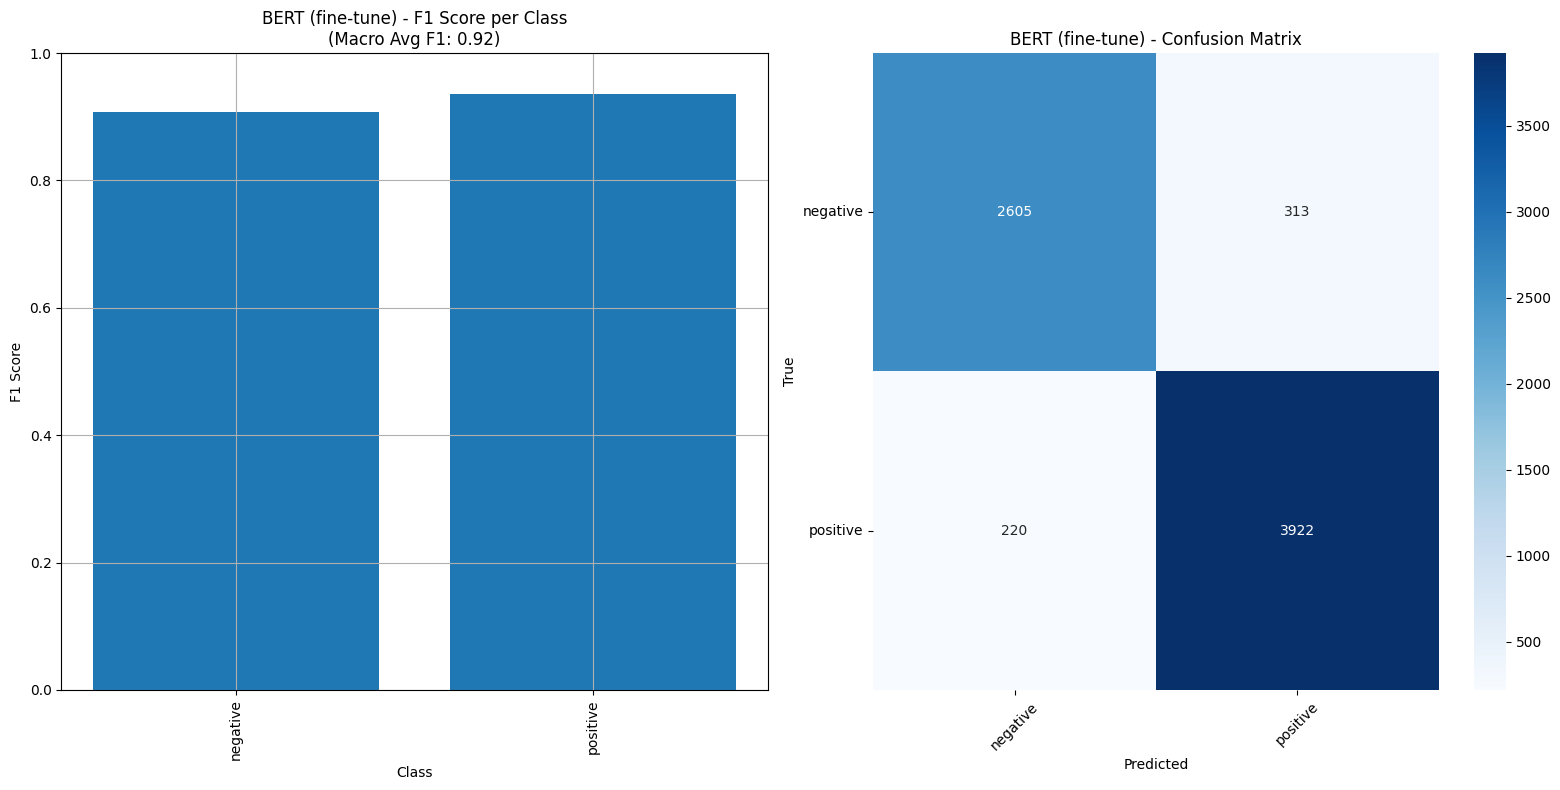

In [28]:
models = {
    "BERT (fine-tune)": model,
}

# Prepare plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.ravel()

# Class labels (human-readable)
class_labels = [decoder[i] for i in sorted(decoder.keys())]

for idx, (name, model) in enumerate(models.items()):
    # Predict class labels
    y_test = metric_df['sentiment'].to_numpy()
    y_pred = metric_df['predicts'].to_numpy()

    # Compute macro F1-score and per-class F1
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Bar chart for per-class F1-scores
    axes[idx].bar(np.arange(len(f1_per_class)), f1_per_class, tick_label=class_labels)
    axes[idx].set_title(f'{name} - F1 Score per Class\n(Macro Avg F1: {f1:.2f})')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('F1 Score')
    axes[idx].set_ylim(0, 1)
    axes[idx].tick_params(axis='x', rotation=90)
    axes[idx].grid(True)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx + 1],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[idx + 1].set_title(f'{name} - Confusion Matrix')
    axes[idx + 1].set_xlabel('Predicted')
    axes[idx + 1].set_ylabel('True')
    axes[idx + 1].tick_params(axis='x', rotation=45)
    axes[idx + 1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
train_df['content']